# Import

In [ ]:
!pip install optuna

import optuna
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import ADASYN, KMeansSMOTE, SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.feature_selection import f_classif, mutual_info_classif, \
    SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.decomposition import PCA, NMF, FactorAnalysis
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.base import clone

from xgboost import XGBClassifier, DMatrix
import xgboost as xgb

import seaborn as sns

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preliminary analysis

In [ ]:
df = pd.read_csv("ST14000NM001G.csv", parse_dates=["date"], dayfirst=True)

C:\Users\Lev\AppData\Local\Temp\ipykernel_2548\3176436983.py:1: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df = pd.read_csv("ST14000NM001G.csv", parse_dates=["date"], dayfirst=True)


In [ ]:
df.date.describe()

count                          7320142
mean     2022-01-07 19:50:33.756558592
min                2020-09-14 00:00:00
25%                2021-07-31 00:00:00
50%                2022-01-20 00:00:00
75%                2022-07-12 00:00:00
max                2022-12-31 00:00:00
Name: date, dtype: object

In [ ]:
df.sample(5)

,date,serial_number,model,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
1880732,2022-01-07,ZL2D4XKK,ST14000NM001G,14000519643136,0,0.0,5543.0,0.0,0.0,1.0,0.0,0.0,0.0,5338.0,5.220651e+10,6.171253e+10
214288,2021-08-06,ZL2994TB,ST14000NM001G,14000519643136,0,0.0,1568.0,0.0,0.0,0.0,0.0,0.0,0.0,938.0,1.679129e+10,1.475695e+10
7168869,2022-02-20,ZTM084K2,ST14000NM001G,14000519643136,0,0.0,5138.0,0.0,0.0,0.0,0.0,0.0,0.0,4751.0,5.136592e+10,6.349512e+10
550250,2022-06-07,ZL2BNS9D,ST14000NM001G,14000519643136,0,0.0,7686.0,0.0,0.0,1.0,0.0,0.0,0.0,7203.0,6.032710e+10,9.394817e+10
2568336,2021-07-22,ZLW15TR5,ST14000NM001G,14000519643136,0,0.0,6436.0,0.0,0.0,3.0,0.0,0.0,0.0,5974.0,6.040795e+10,1.155402e+11


In [ ]:
df.columns

Index(['date', 'serial_number', 'model', 'capacity_bytes', 'failure',
       'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
       'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
       'smart_240_raw', 'smart_241_raw', 'smart_242_raw'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7320142 entries, 0 to 7320141
Data columns (total 16 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   serial_number   object        
 2   model           object        
 3   capacity_bytes  int64         
 4   failure         int64         
 5   smart_5_raw     float64       
 6   smart_9_raw     float64       
 7   smart_187_raw   float64       
 8   smart_188_raw   float64       
 9   smart_192_raw   float64       
 10  smart_197_raw   float64       
 11  smart_198_raw   float64       
 12  smart_199_raw   float64       
 13  smart_240_raw   float64       
 14  smart_241_raw   float64       
 15  smart_242_raw   float64       
dtypes: datetime64[ns](1), float64(11), int64(2), object(2)
memory usage: 893.6+ MB


In [ ]:
df.isna().sum()

date              0
serial_number     0
model             0
capacity_bytes    0
failure           0
smart_5_raw       0
smart_9_raw       0
smart_187_raw     0
smart_188_raw     0
smart_192_raw     0
smart_197_raw     0
smart_198_raw     0
smart_199_raw     0
smart_240_raw     0
smart_241_raw     0
smart_242_raw     0
dtype: int64

In [ ]:
df.model.value_counts()

model
ST14000NM001G    7320142
Name: count, dtype: int64

In [ ]:
df.capacity_bytes.value_counts()

capacity_bytes
14000519643136    7320142
Name: count, dtype: int64

In [ ]:
df.serial_number.value_counts()

serial_number
ZLW17SJW    828
ZLW18SLR    828
ZLW18SGB    828
ZLW17SF1    828
ZLW18SB7    828
           ... 
ZL2MH6QG      8
ZL2MGQQS      8
ZL2E7ET6      8
ZL2CLE1S      5
ZL2N88VG      1
Name: count, Length: 10927, dtype: int64

In [ ]:
df.serial_number.value_counts().unique()

array([828, 824, 823, 819, 817, 816, 806, 805, 804, 803, 802, 799, 787,
       782, 780, 771, 769, 768, 767, 766, 764, 763, 762, 761, 757, 754,
       753, 751, 747, 743, 741, 740, 732, 725, 724, 720, 712, 710, 708,
       706, 699, 698, 689, 688, 682, 678, 673, 672, 661, 660, 659, 657,
       656, 653, 649, 646, 644, 643, 627, 626, 618, 617, 616, 614, 612,
       607, 604, 603, 601, 599, 598, 596, 595, 594, 590, 588, 585, 584,
       577, 576, 575, 574, 573, 572, 571, 570, 569, 568, 567, 564, 559,
       558, 557, 554, 548, 538, 536, 535, 534, 533, 527, 522, 521, 517,
       512, 511, 509, 508, 507, 506, 505, 504, 503, 502, 501, 498, 492,
       489, 483, 480, 479, 471, 470, 468, 465, 463, 457, 452, 448, 447,
       445, 444, 441, 440, 438, 434, 432, 431, 429, 425, 424, 421, 418,
       416, 415, 413, 405, 403, 390, 387, 376, 371, 370, 361, 358, 356,
       349, 347, 342, 341, 340, 339, 336, 333, 332, 327, 323, 321, 319,
       316, 314, 312, 311, 308, 301, 300, 292, 289, 288, 285, 28

* hdd has from 1 to 800 timestapms
* in the each timestamp there are smart_raw values, so we have 10 timeserieses
* column "model" is useless because it has only 1 unique value
* for these reason column "capacity_bytes" is useless too
* only "smart_242_raw" column has nonzero value in the each row

In [ ]:
df[df.serial_number == "ZL2N88VG"].failure

2192999    0
Name: failure, dtype: int64

In [ ]:
df[df.serial_number == df.serial_number[0]]

,date,serial_number,model,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
0,2020-11-14,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,2.406400e+04
1,2020-11-15,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,3.451200e+04
2,2020-11-16,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,3.744000e+04
3,2020-11-17,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,4.036800e+04
4,2020-11-18,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000e+00,5.139200e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
759,2022-12-27,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18570.0,0.0,0.0,3.0,0.0,0.0,0.0,18002.0,1.027798e+11,2.614167e+11
760,2022-12-28,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18602.0,0.0,0.0,3.0,0.0,0.0,0.0,18034.0,1.028692e+11,2.617259e+11
761,2022-12-29,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18618.0,0.0,0.0,3.0,0.0,0.0,0.0,18050.0,1.029110e+11,2.619292e+11
762,2022-12-30,ZL201VZX,ST14000NM001G,14000519643136,0,0.0,18650.0,0.0,0.0,3.0,0.0,0.0,0.0,18082.0,1.030082e+11,2.624393e+11


In [ ]:
df.describe()

,capacity_bytes,failure,smart_5_raw,smart_9_raw,smart_187_raw,smart_188_raw,smart_192_raw,smart_197_raw,smart_198_raw,smart_199_raw,smart_240_raw,smart_241_raw,smart_242_raw
count,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06,7.320142e+06
mean,1.400052e+13,2.349681e-05,6.281509e+00,8.845213e+03,8.674522e-01,1.091258e+09,1.821636e+00,9.649627e-01,9.649627e-01,1.150680e+00,8.405186e+03,6.291207e+10,1.389482e+11
std,0.000000e+00,4.847294e-03,3.428541e+02,5.246619e+03,6.976073e+01,6.852012e+09,5.832090e+01,1.621635e+02,1.621635e+02,1.440507e+01,5.217135e+03,2.500900e+10,9.987568e+10
min,1.400052e+13,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.480000e+03
25%,1.400052e+13,0.000000e+00,0.000000e+00,4.413000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.996000e+03,4.658594e+10,6.532481e+10
50%,1.400052e+13,0.000000e+00,0.000000e+00,8.527000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.089000e+03,6.707800e+10,1.216052e+11
75%,1.400052e+13,0.000000e+00,0.000000e+00,1.267500e+04,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.221100e+04,8.244256e+10,1.850526e+11
max,1.400052e+13,1.000000e+00,6.231200e+04,2.043600e+04,2.123800e+04,1.632112e+11,6.327000e+03,1.180960e+05,1.180960e+05,6.780000e+02,2.001500e+04,1.075645e+11,6.875500e+11


In [ ]:
# imbalanced classes
df.failure.value_counts()

failure
0    7319970
1        172
Name: count, dtype: int64

In [ ]:
df.shape

(7320142, 16)

In [ ]:
# there aren't any duplicates
df.drop_duplicates()
df.shape

(7320142, 16)

In [ ]:
cols = df.select_dtypes(np.number).columns
var = df[cols].var()
to_drop = var[abs(var) <= 1e-15].index
to_drop

Index(['capacity_bytes'], dtype='object')

In [ ]:
cols_with_same_val = df.columns[df.nunique() <= 1].to_list()
cols_with_same_val

['model', 'capacity_bytes']

In [ ]:
fail_models = df[df.failure == 1].serial_number.to_list()
num_work_time = df[df.serial_number.isin(fail_models)]\
    .groupby("serial_number").agg({"serial_number": "count"})
num_work_time.columns = ["cnt_days"]
num_work_time = num_work_time.sort_values("cnt_days")
num_work_time

,cnt_days
serial_number,
ZLW18S8D,12
ZLW18Q2L,44
ZLW18RJ9,45
ZLW18EFV,58
ZLW18EH8,65
...,...
ZLW18RYH,782
ZLW18RH8,787
ZLW18EFL,799


In [ ]:
num_work_time.describe()

,cnt_days
count,172.000000
mean,477.645349
std,211.999577
min,12.000000
25%,306.250000
50%,517.000000
75%,653.750000
max,819.000000


In [ ]:
num_work_time.query("cnt_days < 31")

,cnt_days
serial_number,
ZLW18S8D,12


In [ ]:
df_num_days = df.groupby("serial_number").agg({"serial_number": "count"})
df_num_days.columns = ["cnt_days"]
ser_nums = df_num_days.query("cnt_days > 40").index.to_list()
df_num_days.query("cnt_days < 41").shape[0]

16

In [ ]:
df_sorted = df[df.serial_number.isin(ser_nums)].sort_values(["serial_number", "date"], ascending=[True, True])
df_last_days = df_sorted.groupby("serial_number").tail(41)
fail_models = df_last_days[df_last_days.failure == 1].serial_number.to_list()
df_last_days.failure = df_last_days.failure.mask(df_last_days.serial_number.isin(fail_models), 1)

C:\Users\Lev\AppData\Local\Temp\ipykernel_2548\3577883049.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last_days.failure = df_last_days.failure.mask(df_last_days.serial_number.isin(fail_models), 1)


In [ ]:
# add some timeseries's features
num_cols = df_last_days.select_dtypes(np.number)\
    .drop(["capacity_bytes", "failure"], axis=1).columns.to_list()

def rolling(group, win_size: int):
    if group.name in num_cols:
        diff = group.diff().abs()
        result = diff.rolling(
            window=win_size, min_periods=1, win_type="exponential"
        ).mean(center=win_size, tau=1.5, sym=False)
    else:
        result = group
    return result


def lag(group, lg: int):
    if group.name in num_cols:
        result = group.shift(lg)
        result.name = group.name + f"_lag_{lg}"
    else:
        result = group
    return result


lag5_table = df_last_days.groupby('serial_number').transform(
    lag, lg=5
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
lag5_table.columns = [col + "_lag_5" for col in num_cols]

lag7_table = df_last_days.groupby('serial_number').transform(
    lag, lg=7
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
lag7_table.columns = [col + "_lag_7" for col in num_cols]

lag10_table = df_last_days.groupby('serial_number').transform(
    lag, lg=10
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
lag10_table.columns = [col + "_lag_10" for col in num_cols]

roll5_table = df_last_days.groupby('serial_number').transform(
    rolling, win_size=5
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
roll5_table.columns = [col + "_roll_5" for col in num_cols]

roll7_table = df_last_days.groupby('serial_number').transform(
    rolling, win_size=7
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
roll7_table.columns = [col + "_roll_7" for col in num_cols]

roll10_table = df_last_days.groupby('serial_number').transform(
    rolling, win_size=10
).drop(["date", "model", "failure", "capacity_bytes"], axis=1)
roll10_table.columns = [col + "_roll_10" for col in num_cols]

tmp = pd.concat([
    df_last_days, roll5_table, roll7_table, roll10_table, lag5_table, lag7_table, lag10_table
], axis=1, join="inner").dropna(axis=0)
tmp.to_csv("last_31_days_lag.csv", index=False)

In [ ]:
df_last_days.to_csv("last_41_days.csv")

In [ ]:
df_last_days = pd.read_csv("last_31_days_lag.csv", parse_dates=["date"])\
    .sort_values(by=["serial_number", "date"])

num_day = df_last_days.loc[:, ["date", "serial_number"]].groupby("serial_number", sort=False)\
    .transform(
        lambda series: series if series.name == "serial_number" else list(range(1, series.shape[0] + 1))
    )
num_day.columns = ["num_day"]

pd.concat([num_day, df_last_days], axis=1, join="inner").to_csv("31_days_lag_fix.csv", index=False)

# Work with data

## Functions

In [1]:
def TrainValTestSplit(
    df, y_data=None,
    ignore_cols=[
        "date", "model", "serial_number", "capacity_bytes", "failure"
    ]
):
    """
    return:
        if y_data is None:
            (x_train, x_val, x_test, y_train, y_val, y_test)
        else:
            (x_train, x_test, y_train, y_test)
    """
    if y_data is None:
        df_good = df.loc[df.failure == 0]
        df_bad = df.loc[df.failure == 1]

        df_good = df_good.sort_index()
        df_bad = df_bad.sort_index()

        good_y = df_good["failure"]
        bad_y = df_bad["failure"]
    else:
        df_good = df.loc[y_data == 0]
        df_bad = df.loc[y_data == 1]

        good_y = y_data[y_data == 0]
        bad_y = y_data[y_data == 1]

    # Split into train (80%), valid (20%) and test (20%)
    x_train_good, x_test_good, y_train_good, y_test_good = train_test_split(
        df_good, good_y, train_size=0.8, shuffle=False
    )
    x_train_bad, x_test_bad, y_train_bad, y_test_bad = train_test_split(
        df_bad, bad_y, train_size=0.8, shuffle=False
    )
    if y_data is None:
        x_train_good, x_val_good, y_train_good, y_val_good = train_test_split(
            x_train_good, y_train_good, test_size=0.25, shuffle=False
        )
        x_train_bad, x_val_bad, y_train_bad, y_val_bad = train_test_split(
            x_train_bad, y_train_bad, test_size=0.25, shuffle=False
        )

    x_train = pd.concat([x_train_good, x_train_bad], axis=0).sort_index()
    y_train = pd.concat([y_train_good, y_train_bad], axis=0).sort_index()
    x_test = pd.concat([x_test_good, x_test_bad], axis=0).sort_index()
    y_test = pd.concat([y_test_good, y_test_bad], axis=0).sort_index()

    if y_data is None:
        x_train.drop(ignore_cols, axis=1, inplace=True)

        x_val = pd.concat([x_val_good, x_val_bad], axis=0).sort_index()
        x_val.drop(ignore_cols, axis=1, inplace=True)
        y_val = pd.concat([y_val_good, y_val_bad], axis=0).sort_index()

        x_test.drop(ignore_cols, axis=1, inplace=True)

        return (x_train, x_val, x_test, y_train, y_val, y_test)

    return (x_train, x_test, y_train, y_test)

In [2]:
def FeatureTest(model, x_train, x_test, y_train, y_test) \
-> tuple[list[str], dict[str, list], dict[str, float]]:
    '''
    return:
        (best_feature_name, list_best_features, score_dict)
    '''
    feature_list = {
        "stats": [
            'smart_5_raw',
            'smart_9_raw',
            'smart_240_raw',
            'smart_241_raw',
            'smart_242_raw',
            'smart_241_raw_roll_10',
            'smart_5_raw_lag_5',
            'smart_9_raw_lag_5',
            'smart_240_raw_lag_5',
            'smart_241_raw_lag_5',
            'smart_242_raw_lag_5',
            'smart_9_raw_lag_7',
            'smart_240_raw_lag_7',
            'smart_241_raw_lag_7',
            'smart_242_raw_lag_7',
            'smart_9_raw_lag_10',
            'smart_240_raw_lag_10',
            'smart_241_raw_lag_10',
            'smart_242_raw_lag_10'
        ],
        "stats_without_lag": [
            'smart_5_raw',
            'smart_9_raw',
            'smart_240_raw',
            'smart_241_raw',
            'smart_242_raw'
        ],
        "stats_without_depend": [
            'smart_5_raw',
            'smart_9_raw',
            'smart_241_raw',
            'smart_242_raw',
            'smart_241_raw_roll_10',
            'smart_5_raw_lag_5',
            'smart_9_raw_lag_5',
            'smart_241_raw_lag_5',
            'smart_242_raw_lag_5',
            'smart_9_raw_lag_7',
            'smart_241_raw_lag_7',
            'smart_242_raw_lag_7',
            'smart_9_raw_lag_10',
            'smart_241_raw_lag_10',
            'smart_242_raw_lag_10'
        ],
        "paper": [
            'smart_5_raw',
            'smart_5_raw_roll_5',
            'smart_5_raw_roll_7',
            'smart_5_raw_roll_10',
            'smart_5_raw_lag_5',
            'smart_5_raw_lag_7',
            'smart_5_raw_lag_10',
            'smart_187_raw',
            'smart_187_raw_roll_5',
            'smart_187_raw_roll_7',
            'smart_187_raw_roll_10',
            'smart_187_raw_lag_5',
            'smart_187_raw_lag_7',
            'smart_187_raw_lag_10',
            'smart_188_raw',
            'smart_188_raw_roll_5',
            'smart_188_raw_roll_7',
            'smart_188_raw_roll_10',
            'smart_188_raw_lag_5',
            'smart_188_raw_lag_7',
            'smart_188_raw_lag_10',
            'smart_197_raw',
            'smart_197_raw_roll_5',
            'smart_197_raw_roll_7',
            'smart_197_raw_roll_10',
            'smart_197_raw_lag_5',
            'smart_197_raw_lag_7',
            'smart_197_raw_lag_10',
            'smart_198_raw',
            'smart_198_raw_roll_5',
            'smart_198_raw_roll_7',
            'smart_198_raw_roll_10',
            'smart_198_raw_lag_5',
            'smart_198_raw_lag_7',
            'smart_198_raw_lag_10'
        ],
        "paper_without_lag": [
            'smart_5_raw',
            'smart_187_raw',
            'smart_188_raw',
            'smart_197_raw',
            'smart_198_raw',
        ],
        "paper_without_depend": [
            'smart_5_raw',
            'smart_5_raw_roll_5',
            'smart_5_raw_roll_7',
            'smart_5_raw_roll_10',
            'smart_5_raw_lag_5',
            'smart_5_raw_lag_7',
            'smart_5_raw_lag_10',
            'smart_187_raw',
            'smart_187_raw_roll_5',
            'smart_187_raw_roll_7',
            'smart_187_raw_roll_10',
            'smart_187_raw_lag_5',
            'smart_187_raw_lag_7',
            'smart_187_raw_lag_10',
            'smart_188_raw',
            'smart_188_raw_roll_5',
            'smart_188_raw_roll_7',
            'smart_188_raw_roll_10',
            'smart_188_raw_lag_5',
            'smart_188_raw_lag_7',
            'smart_188_raw_lag_10',
            'smart_197_raw',
            'smart_197_raw_roll_5',
            'smart_197_raw_roll_7',
            'smart_197_raw_roll_10',
            'smart_197_raw_lag_5',
            'smart_197_raw_lag_7',
            'smart_197_raw_lag_10'
        ],
        "elastic_logistic": [
            'smart_188_raw', 'smart_241_raw', 'smart_188_raw_roll_5',
            'smart_241_raw_roll_5', 'smart_188_raw_roll_7',
            'smart_241_raw_roll_7', 'smart_188_raw_roll_10',
            'smart_241_raw_roll_10', 'smart_241_raw_lag_5',
            'smart_242_raw_lag_5', 'smart_188_raw_lag_7',
            'smart_241_raw_lag_7', 'smart_188_raw_lag_10',
            'smart_241_raw_lag_10'
        ],
        "xgb_weight30": [
            'smart_241_raw',
            'smart_9_raw',
            'smart_242_raw',
            'smart_187_raw',
            'smart_242_raw_lag_10',
            'smart_5_raw',
            'smart_240_raw',
            'smart_9_raw_lag_5',
            'smart_197_raw',
            'smart_241_raw_roll_10',
            'smart_241_raw_roll_5',
            'smart_9_raw_lag_10',
            'smart_241_raw_lag_10',
            'smart_241_raw_roll_7',
            'smart_242_raw_lag_7',
            'smart_188_raw',
            'smart_192_raw'
        ],
        "xgb_gain30": [
            'smart_197_raw_roll_10',
            'smart_187_raw',
            'smart_9_raw_lag_10',
            'smart_9_raw_lag_5',
            'smart_240_raw_lag_5',
            'smart_241_raw_roll_7',
            'smart_240_raw',
            'smart_241_raw_roll_10',
            'smart_187_raw_roll_10',
            'smart_242_raw_lag_10',
            'smart_241_raw',
            'smart_9_raw',
            'smart_9_raw_lag_7',
            'smart_187_raw_roll_5',
            'smart_5_raw_lag_5',
            'smart_242_raw_lag_7',
            'smart_241_raw_lag_10'
        ],
        "xgb_total_gain30": [
            'smart_187_raw',
            'smart_241_raw',
            'smart_9_raw_lag_5',
            'smart_9_raw',
            'smart_9_raw_lag_10',
            'smart_240_raw',
            'smart_242_raw_lag_10',
            'smart_197_raw_roll_10',
            'smart_241_raw_roll_7',
            'smart_240_raw_lag_5',
            'smart_241_raw_roll_10',
            'smart_242_raw',
            'smart_5_raw',
            'smart_187_raw_roll_10',
            'smart_241_raw_lag_10',
            'smart_197_raw',
            'smart_242_raw_lag_7'
        ],
        "xgb_cover30": [
            'smart_5_raw_roll_7',
            'smart_197_raw_roll_10',
            'smart_197_raw',
            'smart_9_raw_lag_5',
            'smart_5_raw_lag_5',
            'smart_5_raw_roll_10',
            'smart_187_raw',
            'smart_240_raw_lag_5',
            'smart_241_raw_lag_10',
            'smart_242_raw_lag_7',
            'smart_9_raw_lag_10',
            'smart_187_raw_roll_10',
            'smart_240_raw',
            'smart_5_raw',
            'smart_242_raw_lag_10',
            'smart_5_raw_roll_5',
            'smart_240_raw_lag_7'
        ],
        "default": x_train.columns.to_list(),
        "default_without_lag": [
            'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
            'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
            'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
        ]
    }
    feature_score = {}
    mx = -1
    best_features = ""
    for feature in feature_list:
        estimator = clone(model)
        estimator.fit(x_train.loc[:, feature_list[feature]], y_train)
        preds = estimator.predict(x_test.loc[:, feature_list[feature]])
        if type(estimator).__name__ == "IsolationForest":
          preds = [1 if el == -1 else 0 for el in preds]
        feature_score[feature] = roc_auc_score(y_test, preds)
        if feature_score[feature] > mx:
            mx = feature_score[feature]
            best_features = feature
    return (best_features, feature_list[best_features], feature_score)

In [3]:
def DimReductionTest(model, x_train, x_test, y_train, y_test) \
-> tuple[str, dict[str, float]]:
    '''
    return: ("method_name", scores)
    '''

    scores = {}
    pca = PCA(20)
    x_train_tr = pca.fit_transform(x_train)
    x_test_tr = pca.transform(x_test)
    estimator = clone(model).fit(x_train_tr, y_train)
    preds = estimator.predict(x_test_tr)
    if type(estimator).__name__ == "IsolationForest":
      preds = [1 if el == -1 else 0 for el in preds]
    scores["pca"] = roc_auc_score(y_test, preds)

    nmf = NMF(20, max_iter=500, l1_ratio=0.2)
    x_train_tr = nmf.fit_transform(x_train)
    x_test_tr = nmf.transform(x_test)
    estimator = clone(model).fit(x_train_tr, y_train)
    preds = estimator.predict(x_test_tr)
    if type(estimator).__name__ == "IsolationForest":
      preds = [1 if el == -1 else 0 for el in preds]
    scores["nmf"] = roc_auc_score(y_test, preds)

    fa = FactorAnalysis(20, max_iter=200)
    x_train_tr = fa.fit_transform(x_train)
    x_test_tr = fa.transform(x_test)
    estimator = clone(model).fit(x_train_tr, y_train)
    preds = estimator.predict(x_test_tr)
    if type(estimator).__name__ == "IsolationForest":
      preds = [1 if el == -1 else 0 for el in preds]
    scores["fa"] = roc_auc_score(y_test, preds)

    estimator = clone(model).fit(x_train, y_train)
    preds = estimator.predict(x_test)
    if type(estimator).__name__ == "IsolationForest":
      preds = [1 if el == -1 else 0 for el in preds]
    scores["default"] = roc_auc_score(y_test, preds)

    return max(scores.items(), key=lambda tup: tup[1])[0], scores

In [4]:
def BalancingClassTest(model, x_train, x_test, y_train, y_test)\
-> tuple[str, dict[str, float]]:
    '''
    find best balancing type: default, adasyn, smote

    return:
        ("default" | "adasyn" | "smote", scores)
    '''
    scores = []

    adasyn = ADASYN(n_neighbors=5, random_state=42, sampling_strategy="minority")
    x_resampled, y_resampled = adasyn.fit_resample(x_train, y_train)
    estimator = clone(model).fit(x_resampled, y_resampled)
    scores.append((roc_auc_score(y_test, estimator.predict(x_test)), "adasyn"))

    smote = SMOTE(sampling_strategy="minority", random_state=42)
    x_resampled, y_resampled = smote.fit_resample(x_train, y_train)
    estimator = clone(model).fit(x_resampled, y_resampled)
    scores.append((roc_auc_score(y_test, estimator.predict(x_test)), "smote"))

    kmeanssmote = KMeansSMOTE(
        random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
    )
    x_resampled, y_resampled = kmeanssmote.fit_resample(x_train, y_train)
    estimator = clone(model).fit(x_resampled, y_resampled)
    scores.append((roc_auc_score(y_test, estimator.predict(x_test)), "kmeanssmote"))

    if type(model).__name__ == "XGBClassifier":
      estimator = clone(model).set_params(
          **{"scale_pos_weight": (sum(y_train == 0) / sum(y_train == 1))}
      ).fit(x_train, y_train)
    elif type(model).__name__ == "RandomForestClassifier":
      estimator = clone(model).set_params(**{"class_weight": "balanced"}).fit(x_train, y_train)
    else:
      estimator = clone(model).fit(x_train, y_train)
    scores.append((roc_auc_score(y_test, estimator.predict(x_test)), "default"))

    return max(scores, key=lambda x: x[0])[1], scores

In [5]:
def PreprocessingTest(model, df, need_balancing=True) -> None:
    x_train, _, _, y_train, _, _ = TrainValTestSplit(df)
    x_train, x_test, y_train, y_test = TrainValTestSplit(x_train, y_train)
    cols = x_train.columns
    reduction, dim_scores = DimReductionTest(
        model, x_train, x_test, y_train, y_test
    )
    print(f"Dimensionality reduction: {reduction}")
    print(dim_scores)
    print(100 * "=")

    feature_name, feature_selected, feat_scores = FeatureTest(
        model, x_train, x_test, y_train, y_test
    )
    print(f"Feature selection: {feature_name}")
    len_feat_scores = len(feat_scores)
    key_feat = list(feat_scores.keys())
    for i in range(0, len_feat_scores, 2):
      print(
        f"{key_feat[i]: <20}: {round(feat_scores[key_feat[i]], 5): <10}" + \
        f"{key_feat[i + 1] if i + 1 < len_feat_scores else '': >30}: " + \
        f"{round(feat_scores[key_feat[i + 1]], 5) if i + 1 < len_feat_scores else '': >5}"
      )
    print()
    print(100 * "=")

    best_preproc = {}
    if feature_name != "default" and (reduction == "default" or\
        feat_scores[feature_name] > dim_scores[reduction]):
      x_train = x_train.loc[:, feature_selected]
      x_test = x_test.loc[:, feature_selected]
      best_preproc["features"] = feature_name
    elif reduction == "pca":
        pca = PCA(20)
        x_train = pd.DataFrame(pca.fit_transform(x_train))
        x_test = pd.DataFrame(pca.transform(x_test))
        best_preproc["features"] = reduction
    elif reduction == "nmf":
        nmf = NMF(20, max_iter=400, l1_ratio=0.2)
        x_train = pd.DataFrame(nmf.fit_transform(x_train))
        x_test = pd.DataFrame(nmf.transform(x_test))
        best_preproc["features"] = reduction
    elif reduction == "fa":
        fa = FactorAnalysis(20, max_iter=200)
        x_train = pd.DataFrame(fa.fit_transform(x_train))
        x_test = pd.DataFrame(fa.transform(x_test))
        best_preproc["features"] = reduction
    else:
      best_preproc["features"] = "default"

    if need_balancing:
      balancing, balance_scores = BalancingClassTest(
          model, x_train, x_test, y_train, y_test
      )
      print(f"Balancing class: {balancing}")
      print(balance_scores)
      print(100 * "=")
      match balancing:
          case "adasyn":
              ada = ADASYN(n_neighbors=10, random_state=42, sampling_strategy="minority")
              best_preproc["balancing"] = str(ada)
              x_train, y_train = ada.fit_resample(x_train, y_train)
              x_train = pd.DataFrame(x_train, columns=cols)
          case "smote":
              smote = SMOTE(sampling_strategy="minority")
              best_preproc["balancing"] = str(smote)
              x_train, y_train = smote.fit_resample(x_train, y_train)
              x_train = pd.DataFrame(x_train, columns=cols)
          case "kmeanssmote":
              kmeanssmote = KMeansSMOTE(
                  random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
              )
              best_preproc["balancing"] = str(kmeanssmote)
              x_train, y_train = kmeanssmote.fit_resample(x_train, y_train)
              x_train = pd.DataFrame(x_train, columns=cols)
          case "default":
              best_preproc["balancing"] = "default balancing"
    print("Conclusion:")
    print("\n".join([": ".join([key, str(val)]) for key, val in best_preproc.items()]))

In [6]:
class CVSplitter:

  def __init__(self, n_splits=3, train_size=0.8):
    if n_splits < 2:
      raise Exception("too less splits")
    if train_size < 0.5 or train_size >= 1:
      raise Exception("wrong train_size")
    self.n_splits = n_splits
    self.train_size = train_size

  def split(self, x, y=None, groups=None):
    if isinstance(x, pd.DataFrame):
      x_data = pd.DataFrame(x.values, index=list(range(x.shape[0])))
    else:
      x_data = pd.DataFrame(x, index=list(range(x.shape[0])))
    split_size = x_data.shape[0] // self.n_splits
    split_train_size = round(self.train_size * split_size)
    for i in range(self.n_splits):
      if i == self.n_splits - 1:
        split = x_data.iloc[i * split_size:].index.to_list()
      else:
        split = x_data.iloc[i * split_size:(i + 1) * split_size].index.to_list()
      yield (
          split[:split_train_size],
          split[split_train_size:]
      )

  def get_n_splits(self, X=None, y=None, groups=None):
    return self.n_splits

## Feature selection

Resume features extract:
* by statistical dependency
* by paper of related work
* by logistic elastic select
* by xgb

In [ ]:
# num_cols = ['smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
#        'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
#        'smart_240_raw', 'smart_241_raw', 'smart_242_raw']
df_last_days = pd.read_csv(
    "/content/drive/MyDrive/31_days_lag_fix.csv", parse_dates=["date"],
    index_col="num_day"
)
x_train, x_val, x_test, y_train, y_val, y_test = TrainValTestSplit(df_last_days)
num_cols = x_train.select_dtypes(np.number).columns.to_list()

### Select from statistic

In [ ]:
f_selected, p_val = f_classif(x_train[num_cols], y_train)
f_selected /= np.max(f_selected)
mi_selected = mutual_info_classif(x_train[num_cols], y_train)
mi_selected /= np.max(mi_selected)

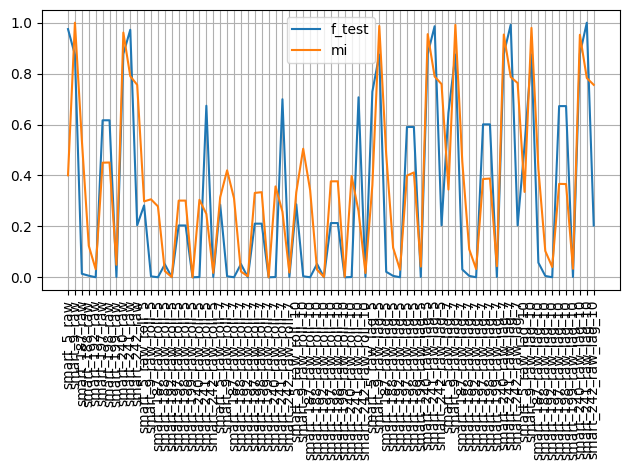

In [ ]:
plt.plot(f_selected, label="f_test")
plt.xticks(ticks=range(len(num_cols)), labels=num_cols, rotation=90)
plt.plot(mi_selected, label="mi")
plt.legend()
plt.grid()
plt.tight_layout()

In [ ]:
stats_feat_sel = np.array(num_cols)[(f_selected > 0.7) | (mi_selected > 0.7)].tolist()
paper_feat_sel = [
    col for name in [
        "smart_5_raw", "smart_187_raw", "smart_188_raw", "smart_197_raw", "smart_198_raw"
       ] for col in num_cols if col.startswith(name)

]

* del smart_198_raw due to the fact that it's strongly correlated with smart_197_raw
and the last one has a bit more dependence to failure

* del smart_240_raw and take smart_9_raw to replace it

<Axes: >

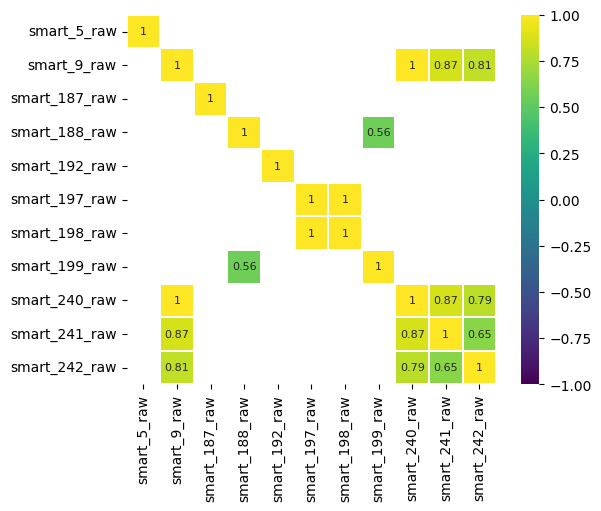

In [ ]:
correlated = x_train[
    [
        'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
        'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
        'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
    ]
].corr()
sns.heatmap(
    correlated[(correlated > 0.5) | (correlated <= -0.5)],
    cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
    annot=True, annot_kws={"size": 8}, square=True
)

In [ ]:
stats_feat_sel = [
    col for col in stats_feat_sel if not col.startswith("smart_240_raw") and \
        not col.startswith("smart_198_raw")
]
paper_feat_sel = [
    col for col in paper_feat_sel if not col.startswith("smart_240_raw") and \
        not col.startswith("smart_198_raw")
]

### Select from model

In [ ]:
logistic_feat_sel = SelectFromModel(LogisticRegression(
    "elasticnet", class_weight="balanced", solver="saga", max_iter=600, C=0.8,
    l1_ratio=0.3
)).fit(x_train.loc[:, num_cols], y_train).get_feature_names_out(num_cols)
logistic_feat_sel

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


array(['smart_188_raw', 'smart_241_raw', 'smart_188_raw_roll_5',
       'smart_241_raw_roll_5', 'smart_188_raw_roll_7',
       'smart_241_raw_roll_7', 'smart_188_raw_roll_10',
       'smart_241_raw_roll_10', 'smart_241_raw_lag_5',
       'smart_242_raw_lag_5', 'smart_188_raw_lag_7',
       'smart_241_raw_lag_7', 'smart_188_raw_lag_10',
       'smart_241_raw_lag_10'], dtype=object)

In [ ]:
xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)

dtrain = DMatrix(xtrain, label=ytrain)
dtest = DMatrix(xtest, label=ytest)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'eval_metric': 'auc',
    'reg_alpha': 0.15,
    'tree_method': 'exact'
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=10,
    verbose_eval=50
)

[0]	train-auc:0.91144	eval-auc:0.92822
[50]	train-auc:0.99952	eval-auc:0.99652
[67]	train-auc:0.99992	eval-auc:0.99574


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

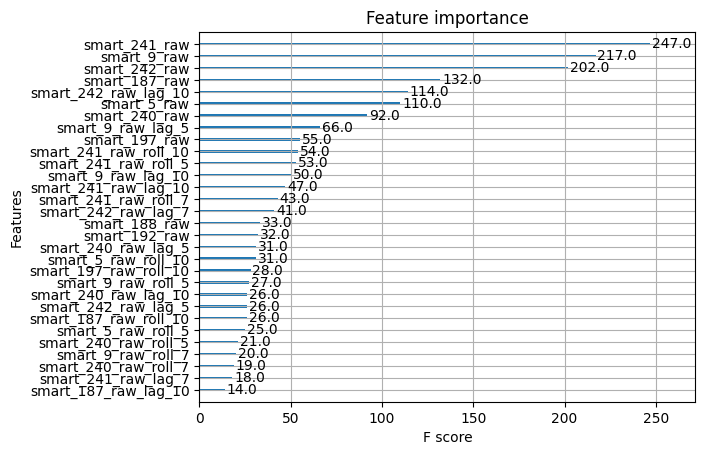

In [ ]:
xgb.plot_importance(bst, max_num_features=30)

In [ ]:
weight = sorted(bst.get_score(importance_type="weight").items(), key=lambda x: -x[1])
weight = [feature for feature, val in weight[:len(weight) // 3]]
gain = sorted(bst.get_score(importance_type="gain").items(), key=lambda x: -x[1])
gain = [feature for feature, val in gain[:len(gain) // 3]]
total_gain = sorted(bst.get_score(importance_type="total_gain").items(), key=lambda x: -x[1])
total_gain = [feature for feature, val in total_gain[:len(total_gain) // 3]]
cover = sorted(bst.get_score(importance_type="cover").items(), key=lambda x: -x[1])
cover = [feature for feature, val in cover[:len(cover) // 3]]

## Dimensionality reduction

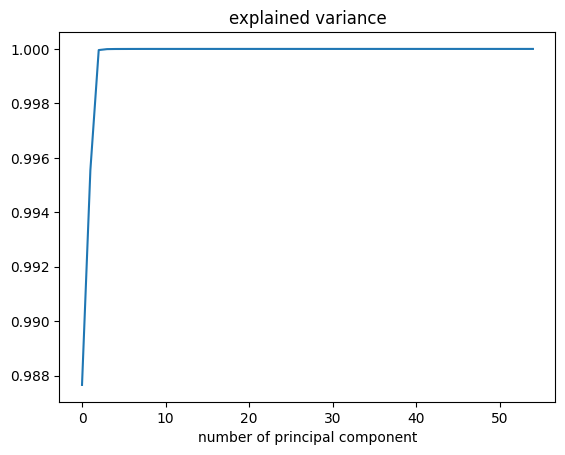

[0.98765971 0.99554331 0.99995792 0.99999252 0.99999722 0.99999817
 0.99999898 0.99999943 0.99999971 0.99999986 0.99999991 0.99999996
 0.99999999 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.        ]


In [ ]:
pca = PCA()
pca.fit(x_train[num_cols])
explained_var = np.cumsum(pca.explained_variance_ratio_)
plt.plot(explained_var)
plt.title("explained variance")
plt.xlabel("number of principal component");
plt.show()
print(explained_var)

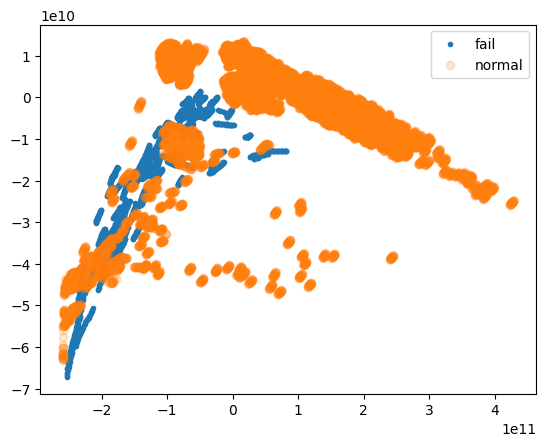

In [ ]:
pca = PCA()
pca.fit(x_train[num_cols])
plt.scatter(
    pca.transform(x_train.loc[y_train == 1, num_cols])[:, 0],
    pca.transform(x_train.loc[y_train == 1, num_cols])[:, 1],
    label="fail", marker="."
);
plt.scatter(
    pca.transform(x_train.loc[y_train == 0, num_cols])[:, 0],
    pca.transform(x_train.loc[y_train == 0, num_cols])[:, 1],
    label="normal", marker="o", alpha=0.2
);
plt.legend()
plt.show()

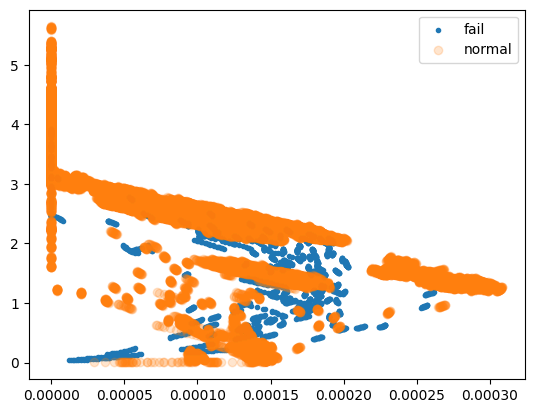

In [ ]:
from sklearn.decomposition import NMF

nmf = NMF(2)
nmf.fit(x_train[num_cols])
plt.scatter(
    nmf.transform(x_train.loc[y_train == 1, num_cols])[:, 0],
    nmf.transform(x_train.loc[y_train == 1, num_cols])[:, 1],
    label="fail", marker="."
);
plt.scatter(
    nmf.transform(x_train.loc[y_train == 0, num_cols])[:, 0],
    nmf.transform(x_train.loc[y_train == 0, num_cols])[:, 1],
    label="normal", marker="o", alpha=0.2
);
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_factor_analysis.py:296: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  warnings.warn(


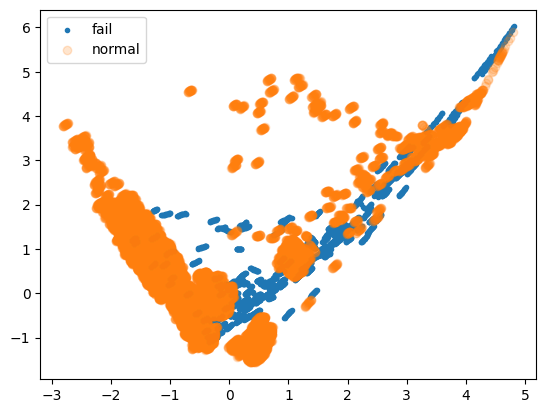

In [ ]:
from sklearn.decomposition import FactorAnalysis

fa = FactorAnalysis(2, max_iter=100)
fa.fit(x_train[num_cols])
plt.scatter(
    fa.transform(x_train.loc[y_train == 1, num_cols])[:, 0],
    fa.transform(x_train.loc[y_train == 1, num_cols])[:, 1],
    label="fail", marker="."
);
plt.scatter(
    fa.transform(x_train.loc[y_train == 0, num_cols])[:, 0],
    fa.transform(x_train.loc[y_train == 0, num_cols])[:, 1],
    label="normal", marker="o", alpha=0.2
);
plt.legend()
plt.show()

## Class balancing

In [ ]:
adasyn = ADASYN(n_neighbors=10, random_state=42, sampling_strategy="minority")
x_resampled, y_resampled = adasyn.fit_resample(x_train[num_cols], y_train)
y_resampled.value_counts()

In [ ]:
kmeanssmote = KMeansSMOTE(
    random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
)
x_resampled, y_resampled = kmeanssmote.fit_resample(x_train[num_cols], y_train)
y_resampled.value_counts()

failure
0    266352
1    266352
Name: count, dtype: int64

## Model evaluation

Define to use:
* XGBClassifier
* BalancedRandomForestClassifier
* RandomForestClassifier
* IsolationForest
* Stacking

In [ ]:
df_last_days = pd.read_csv(
    "/content/drive/MyDrive/31_days_lag_fix.csv", parse_dates=["date"],
    index_col="num_day"
)

In [12]:
x_train, x_val, x_test, y_train, y_val, y_test = TrainValTestSplit(df_last_days)

### Stacking

In [ ]:
# Created based on egaoharu_kensei's code: https://habr.com/ru/articles/799483/

from joblib import Parallel, delayed
from sklearn.model_selection import cross_val_predict

class Stacking:

    def __init__(
      self, estimators: list[tuple[str, any]], final_estimator, blending=False,
      cv=CVSplitter(2), n_jobs=-1
    ):
        self.estimators = {name: model for name, model in estimators}
        self.final_estimator = final_estimator
        self.blending = blending
        self.cv = cv
        self.n_jobs = n_jobs
        self._is_fitted = False

    def _X_pred(self, estimator, data):
        if self.blending:
            X_train_v, y_train_v, X_val = data
            return self.estimators[estimator].fit(X_train_v, y_train_v).predict(X_val)
        else:
            X_train, y_train = data
            return cross_val_predict(self.estimators[estimator], X_train, y_train, cv=self.cv)

    def _X_test_pred(self, estimator, data):
        X_train, y_train, X_test = data
        self.estimators[estimator].fit(X_train, y_train)
        return (estimator, self.estimators[estimator]),\
            self.estimators[estimator].predict_proba(X_test)[:, 1]


    def _meta_data(self, X_train, y_train, X_test):
        if self.blending:
            #used hold-out cross-validation
            X_train_v, X_val, y_train_v, y_val = train_test_split(
                X_train, y_train, shuffle=False, random_state=42,
                test_size=0.2
            )
            train_data = [X_train_v, y_train_v, X_val]
            test_data = [X_train_v, y_train_v, X_test]
            meta_y_train = y_val
        else:
            train_data = [X_train, y_train]
            test_data = [X_train, y_train, X_test]
            meta_y_train = y_train

        cv_X_train_preds = (delayed(self._X_pred)(est, train_data) for est in self.estimators)
        X_test_preds = (delayed(self._X_test_pred)(est, test_data) for est in self.estimators)

        meta_X_train = pd.DataFrame(Parallel(n_jobs=self.n_jobs)(cv_X_train_preds))
        tuples = Parallel(n_jobs=self.n_jobs)(X_test_preds)
        meta_X_test = []
        for (name, est), test_data in tuples:
          self.estimators[name] = est
          meta_X_test.append(test_data)
        meta_X_test = pd.DataFrame(meta_X_test)

        return meta_X_train.T, meta_y_train, meta_X_test.T

    def fit_predict(self, X_train, y_train, X_test):
        # meta learner or blender
        meta_X_train, meta_y_train, meta_X_test = self._meta_data(X_train, y_train, X_test)
        self.final_estimator = self.final_estimator.fit(meta_X_train, meta_y_train)
        self._is_fitted = True
        return self.final_estimator.predict_proba(meta_X_test)[:, 1]

    def fit(self, X_train, y_train, X_test):
        meta_X_train, meta_y_train, meta_X_test = self._meta_data(X_train, y_train, X_test)
        self.final_estimator.fit(meta_X_train, meta_y_train)
        self._is_fitted = True
        return self

    def predict(self, X_test):
        meta_X_test = []
        for name, est in self.estimators.items():
          meta_X_test.append(est.predict_proba(X_test)[:, 1])
        return self.final_estimator.predict_proba(np.array(meta_X_test).T)[:, 1]

In [ ]:
default_without_lag = [
    'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
    'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
    'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
]

kmeanssmote = KMeansSMOTE(
    random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
)

xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)
x_train_res, y_train_res = kmeanssmote.fit_resample(xtrain, ytrain)

def objective(trial):
  rfc = RandomForestClassifier(
      n_estimators=trial.suggest_int("n_estims_rfc", 3, 100),
      max_depth=trial.suggest_int("max_depth_rfc", 7, 30), n_jobs=-1, random_state=42
  )
  num_rfc = trial.suggest_int("num_rfc_estimators", 3, 6)
  estimators = [(f"rfc{i}", clone(rfc)) for i in range(num_rfc)]
  estimators += [
      ("xgb1", XGBClassifier(
              max_depth=trial.suggest_int("max_depth_xgb", 3, 10),
              n_esimators=trial.suggest_int("n_estims_xgb", 30, 100, step=10)
      ))
  ]
  stacking = Stacking(
      estimators=estimators,
      final_estimator=LogisticRegression(
        "elasticnet", solver="saga", max_iter=100, C=1, l1_ratio=0.1
      ),
      blending=True
  )

  return roc_auc_score(
      ytest, stacking.fit_predict(
          xtrain.loc[:, default_without_lag],
          ytrain, xtest.loc[:, default_without_lag]
      )
  )

study = optuna.create_study(study_name="stacking", direction="maximize")
study.optimize(objective, n_trials=100)
print(study.best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The KMeansSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2024-12-24 12:55:46,118] A new study created in memory with name: stacking
[I 2024-12-24 12:56:14,892] Trial 0 finished with value: 0.9924525901267323 and parameters: {'n_esti

{'n_estims_rfc': 31, 'max_depth_rfc': 14, 'num_rfc_estimators': 4, 'max_depth_xgb': 8, 'n_estims_xgb': 50}


In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.base import clone

default_without_lag = [
    'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
    'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
    'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
]
rfc = RandomForestClassifier(
    n_estimators=31, max_depth=14, n_jobs=-1, random_state=42
)

kmeanssmote = KMeansSMOTE(
    random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
)

xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)
x_train_res, y_train_res = kmeanssmote.fit_resample(xtrain, ytrain)

stacking = Stacking(
    estimators=[
        ("rfc1", clone(rfc)), ("rfc2", clone(rfc)), ("rfc3", clone(rfc)),
        ("rfc4", clone(rfc)), ("xgb1", XGBClassifier(max_depth=8, n_esimators=50))
    ],
    final_estimator=LogisticRegression(
      "elasticnet", solver="saga", max_iter=100, C=1, l1_ratio=0.1
    ),
    blending=True
)

stacking.fit(
    xtrain.loc[:, default_without_lag],
    ytrain, xtest.loc[:, default_without_lag]
)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The KMeansSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
print(roc_auc_score(ytest, stacking.predict(xtest.loc[:, default_without_lag])))

0.9971011142494948


In [ ]:
print(roc_auc_score(y_val, stacking.predict(x_val.loc[:, default_without_lag])))

0.9910354690232588


In [ ]:
print(classification_report(
    y_val,
    (stacking.predict(x_val.loc[:, default_without_lag]) > 0.2).astype(int)
))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66588
           1       0.89      0.94      0.91      1060

    accuracy                           1.00     67648
   macro avg       0.94      0.97      0.96     67648
weighted avg       1.00      1.00      1.00     67648



In [ ]:
import optuna

smote = SMOTE(random_state=42, sampling_strategy="minority")

xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)
x_train_res, y_train_res = smote.fit_resample(xtrain, ytrain)

def objective(trial):
  estimators = [
      ("xgb1", XGBClassifier(
              max_depth=trial.suggest_int("max_depth_xgb1", 3, 10),
              n_esimators=trial.suggest_int("n_estims_xgb1", 30, 100, step=10)
      )),
      ("xgb2", XGBClassifier(
              max_depth=trial.suggest_int("max_depth_xgb2", 3, 10),
              n_esimators=trial.suggest_int("n_estims_xgb2", 30, 100, step=10)
      )),
      ("xgb3", XGBClassifier(
              max_depth=trial.suggest_int("max_depth_xgb3", 3, 10),
              n_esimators=trial.suggest_int("n_estims_xgb3", 30, 100, step=10)
      ))
  ]
  stacking = Stacking(
      estimators=estimators,
      final_estimator=LogisticRegression(
        "elasticnet", solver="saga", max_iter=100, C=1, l1_ratio=0.1
      ),
      blending=True
  )

  return roc_auc_score(
      ytest, stacking.fit_predict(
          xtrain.loc[:, default_without_lag],
          ytrain, xtest.loc[:, default_without_lag]
      )
  )

study = optuna.create_study(study_name="stacking xgb", direction="maximize")
study.optimize(objective, n_trials=350)
print(study.best_params)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2024-12-24 15:04:56,994] A new study created in memory with name: stacking xgb
[I 2024-12-24 15:05:09,179] Trial 0 finished with value: 0.9956635760855483 and parameters: {'max_dept

{'max_depth_xgb1': 6, 'n_estims_xgb1': 90, 'max_depth_xgb2': 6, 'n_estims_xgb2': 40, 'max_depth_xgb3': 5, 'n_estims_xgb3': 60}


In [ ]:
smote = SMOTE(random_state=42, sampling_strategy="minority")

xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)
x_train_res, y_train_res = smote.fit_resample(xtrain, ytrain)

estimators = [
      ("xgb1", XGBClassifier(
              max_depth=6,
              n_esimators=90
      )),
      ("xgb2", XGBClassifier(
              max_depth=6,
              n_esimators=40
      )),
      ("xgb3", XGBClassifier(
              max_depth=5,
              n_esimators=60
      ))
]
stacking = Stacking(
      estimators=estimators,
      final_estimator=LogisticRegression(
        "elasticnet", solver="saga", max_iter=100, C=1, l1_ratio=0.1
      ),
      blending=True
)

stacking.fit(
      xtrain.loc[:, default_without_lag],
      ytrain, xtest.loc[:, default_without_lag]
)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [ ]:
print(roc_auc_score(ytest, stacking.predict(xtest.loc[:, default_without_lag])))

0.9970059946222976


In [ ]:
print(roc_auc_score(y_val, stacking.predict(x_val.loc[:, default_without_lag])))

0.9928529957803037


In [ ]:
print(classification_report(
    y_val,
    (stacking.predict(x_val.loc[:, default_without_lag]) > 0.2).astype(int)
))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     66588
           1       0.65      0.87      0.74      1060

    accuracy                           0.99     67648
   macro avg       0.82      0.93      0.87     67648
weighted avg       0.99      0.99      0.99     67648



### XGBClassifier

In [ ]:
PreprocessingTest(XGBClassifier(), df_last_days)

Dimensionality reduction: default
{'pca': 0.8904229175255769, 'nmf': 0.5052505876795171, 'fa': 0.9629001380080714, 'default': 0.9793071914531021}
Feature selection: default
stats                         : 0.95373                stats_without_lag: 0.92832
stats_without_depend          : 0.94249                            paper: 0.80076
paper_without_lag             : 0.7662              paper_without_depend: 0.80076
elastic_logistic              : 0.87014                     xgb_weight30: 0.9709
xgb_gain30                    : 0.96708                 xgb_total_gain30: 0.9694
xgb_cover30                   : 0.95043                          default: 0.97931
default_without_lag           : 0.94819                                 :      



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The ADASYN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validati

Balancing class: smote
[(0.972782366765226, 'adasyn'), (0.9889413889937029, 'smote'), (0.9814551949169205, 'kmeanssmote'), (0.9836714979723816, 'default')]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Conclusion:
features: default
balancing: SMOTE(sampling_strategy='minority')


In [ ]:
xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)

smote = SMOTE(random_state=42, sampling_strategy="minority")
x_train_res, y_train_res = smote.fit_resample(xtrain, ytrain)

dtrain = DMatrix(x_train_res, label=y_train_res)
dtest = DMatrix(xtest, label=ytest)

params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.1,
    'eval_metric': 'auc',
    'reg_alpha': 0.15,
    'tree_method': 'exact'
}

bst = xgb.train(
    params,
    dtrain,
    num_boost_round=200,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=20,
    verbose_eval=10
)
print(roc_auc_score(ytest, bst.predict(dtest)))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


[0]	train-auc:0.99033	eval-auc:0.97792
[10]	train-auc:0.99607	eval-auc:0.98927
[20]	train-auc:0.99895	eval-auc:0.99287
[30]	train-auc:0.99960	eval-auc:0.99556
[40]	train-auc:0.99991	eval-auc:0.99566
[50]	train-auc:0.99996	eval-auc:0.99625
[60]	train-auc:0.99999	eval-auc:0.99580
[70]	train-auc:0.99999	eval-auc:0.99559
[71]	train-auc:0.99999	eval-auc:0.99556
0.9954870518456671


In [ ]:
roc_auc_score(y_val, bst.predict(DMatrix(x_val)))

0.9929453405962432

In [ ]:
params = {
    'max_depth': 10,
    'learning_rate': 0.6976221181817422,
    'reg_alpha': 0.4658008664640824,
    'reg_lambda': 0.24406814687588438,
    'grow_policy': 'depthwise',
    'tree_method': 'exact'
}

num_boost_round = 150

In [ ]:
smote = SMOTE(random_state=42, sampling_strategy="minority")
x_train_res, y_train_res = smote.fit_resample(x_train, y_train)
dtrain = DMatrix(x_train_res, label=y_train_res)
dtest = DMatrix(x_val)

bst = xgb.train(
      params,
      dtrain,
      num_boost_round=num_boost_round
)
print(f"train: {roc_auc_score(y_train, bst.predict(DMatrix(x_train)))}")
print(f"val: {roc_auc_score(y_val, bst.predict(dtest))}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


train: 1.0
val: 0.9897210217490601


### IsolationForest

In [ ]:
PreprocessingTest(IsolationForest(random_state=42), df_last_days, need_balancing=False)

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1741: ConvergenceWarning: Maximum number of iterations 400 reached. Increase it to improve convergence.
  warnings.warn(


Dimensionality reduction: default
{'pca': 0.6087052050310058, 'nmf': 0.5, 'fa': 0.7191295487606743, 'default': 0.812871653280655}
Feature selection: xgb_gain30
stats: 0.91106                            stats_without_lag: 0.90782                            
stats_without_depend: 0.91051                            paper: 0.7724                             
paper_without_lag: 0.77953                            paper_without_depend: 0.76422                            
elastic_logistic: 0.72249                            xgb_weight30: 0.88751                            
xgb_gain30: 0.91978                            xgb_total_gain30: 0.90469                            
xgb_cover30: 0.91302                            default: 0.79661                            
default_without_lag: 0.86684                            
Conclusion:
features: xgb_gain30


In [ ]:
iforest = IsolationForest(n_jobs=-1)
xgb_gain30 = [
            'smart_197_raw_roll_10',
            'smart_187_raw',
            'smart_9_raw_lag_10',
            'smart_9_raw_lag_5',
            'smart_240_raw_lag_5',
            'smart_241_raw_roll_7',
            'smart_240_raw',
            'smart_241_raw_roll_10',
            'smart_187_raw_roll_10',
            'smart_242_raw_lag_10',
            'smart_241_raw',
            'smart_9_raw',
            'smart_9_raw_lag_7',
            'smart_187_raw_roll_5',
            'smart_5_raw_lag_5',
            'smart_242_raw_lag_7',
            'smart_241_raw_lag_10'
]
params = {
    "n_estimators": [100, 200, 300, 400],
    "bootstrap": [False, True],
    "max_samples": [0.5, 0.8, "auto"],
    "contamination": [0.1, "auto"]
}
random_search = RandomizedSearchCV(
    iforest, params, n_iter=40, scoring="roc_auc", cv=CVSplitter(2), n_jobs=-1
)
random_search.fit(x_train[xgb_gain30].values, y_train.values)

RandomizedSearchCV(cv=<__main__.CVSplitter object at 0x7cd259152650>,
                   estimator=IsolationForest(n_jobs=-1), n_iter=40, n_jobs=-1,
                   param_distributions={'bootstrap': [False, True],
                                        'contamination': [0.1, 'auto'],
                                        'max_samples': [0.5, 0.8, 'auto'],
                                        'n_estimators': [100, 200, 300, 400]},
                   scoring='roc_auc')

In [ ]:
print(roc_auc_score(
    y_train.values,
    [1 if outl == -1 else 0 for outl in random_search.predict(x_train[xgb_gain30].values)]
))

0.9378339364978977


In [ ]:
print(roc_auc_score(
    y_val.values,
    [1 if outl == -1 else 0 for outl in random_search.predict(x_val[xgb_gain30].values)]
))

0.8857920742702805


In [ ]:
print(classification_report(
    y_val.values,
    [1 if outl == -1 else 0 for outl in random_search.predict(x_val[xgb_gain30].values)]
))

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     66588
           1       0.07      0.96      0.14      1060

    accuracy                           0.81     67648
   macro avg       0.54      0.89      0.52     67648
weighted avg       0.98      0.81      0.88     67648



### BalancedRandomForestClassifier

In [ ]:
PreprocessingTest(
    BalancedRandomForestClassifier(random_state=42), df_last_days, need_balancing=False
)

/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.10/dist-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/usr/local/lib/python3.

Dimensionality reduction: default
{'pca': 0.9305187329388761, 'nmf': 0.5260515028114009, 'fa': 0.9757792450154088, 'default': 0.983802371087915}


Выходные данные были обрезаны до нескольких последних строк (5000).
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
/usr/local/lib/python3.

Feature selection: default_without_lag
stats: 0.98168	stats_without_lag: 0.97974
stats_without_depend: 0.98013	paper: 0.85926
paper_without_lag: 0.85266	paper_without_depend: 0.85758
elastic_logistic: 0.94181	xgb_weight30: 0.98453
xgb_gain30: 0.98355	xgb_total_gain30: 0.98445
xgb_cover30: 0.98191	default: 0.98373
default_without_lag: 0.98706	
Conclusion:
features: default_without_lag


In [ ]:
default_without_lag = [
    'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
    'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
    'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
]
params = {
    "n_estimators": [100, 200, 300],
    "max_depth": list(range(5, 17, 2)) + [None],
    "class_weight": ["balanced", None],
    "sampling_strategy": ["all", "not majority"]
}

search = RandomizedSearchCV(
    BalancedRandomForestClassifier(
        replacement=True, bootstrap=False, n_jobs=-1
    ), params, n_iter=50, scoring="roc_auc", cv=CVSplitter(n_splits=2)
)

search.fit(x_train[default_without_lag].values, y_train.values)

RandomizedSearchCV(cv=<__main__.CVSplitter object at 0x7ae8e3f5ac80>,
                   estimator=BalancedRandomForestClassifier(bootstrap=False,
                                                            n_jobs=-1,
                                                            replacement=True),
                   n_iter=50,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [5, 7, 9, 11, 13, 15,
                                                      None],
                                        'n_estimators': [100, 200, 300],
                                        'sampling_strategy': ['all',
                                                              'not majority']},
                   scoring='roc_auc')

In [ ]:
roc_auc_score(y_train.values, search.predict(x_train[default_without_lag].values))

1.0

In [ ]:
roc_auc_score(y_val.values, search.predict(x_val[default_without_lag].values))

0.957487098927678

### RandomForestClassifier

In [ ]:
PreprocessingTest(RandomForestClassifier(random_state=42), df_last_days)

Dimensionality reduction: default
{'pca': 0.8921329063221612, 'nmf': 0.5214972128414408, 'fa': 0.9572968757157585, 'default': 0.9809318401952483}
Feature selection: default_without_lag
stats               : 0.96573                stats_without_lag: 0.96201
stats_without_depend: 0.95905                            paper: 0.80361
paper_without_lag   : 0.77162             paper_without_depend: 0.80525
elastic_logistic    : 0.88486                     xgb_weight30: 0.97668
xgb_gain30          : 0.97186                 xgb_total_gain30: 0.9741
xgb_cover30         : 0.97688                          default: 0.98093
default_without_lag : 0.98243                                 :      



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The ADASYN or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validati

Balancing class: kmeanssmote
[(0.9541410449731266, 'adasyn'), (0.9755788719984976, 'smote'), (0.9825291966488297, 'kmeanssmote'), (0.9669561026659156, 'default')]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The KMeansSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Conclusion:
features: default_without_lag
balancing: KMeansSMOTE(cluster_balance_threshold=0.1, random_state=42,
            sampling_strategy='minority')


In [ ]:
default_without_lag = [
    'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
    'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
    'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
]
rfc = RandomForestClassifier(n_jobs=-1)
params = {
    "n_estimators": [100, 200, 300, 400],
    "max_depth": list(range(5, 15, 2)) + [None]
}

kmeanssmote = KMeansSMOTE(
    random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
)
x_train_res, y_train_res = kmeanssmote.fit_resample(x_train, y_train)

rfsearch = RandomizedSearchCV(
    rfc, params, n_iter=20, scoring="roc_auc", n_jobs=-1, cv=CVSplitter(2)
)
rfsearch.fit(x_train_res[default_without_lag].values, y_train_res.values)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(


RandomizedSearchCV(cv=<__main__.CVSplitter object at 0x7ae8e3f9fa60>,
                   estimator=RandomForestClassifier(n_jobs=-1), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'max_depth': [5, 7, 9, 11, 13, None],
                                        'n_estimators': [100, 200, 300, 400]},
                   scoring='roc_auc')

In [ ]:
default_without_lag = [
    'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
    'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
    'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
]

kmeanssmote = KMeansSMOTE(
    random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
)
xtrain, xtest, ytrain, ytest = TrainValTestSplit(x_train, y_train)
x_train_res, y_train_res = kmeanssmote.fit_resample(xtrain, ytrain)

def objective(trial):
  rfc = RandomForestClassifier(
      n_estimators=trial.suggest_int("n_estimators", 50, 510, step=20),
      max_depth=trial.suggest_int("max_depth", 3, 30),
      min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 7),
      min_samples_split=trial.suggest_int("min_samples_split", 2, 8),
      random_state=42, n_jobs=-1
  )
  rfc.fit(x_train_res.loc[:, default_without_lag], y_train_res)
  return roc_auc_score(ytest, rfc.predict_proba(xtest.loc[:, default_without_lag])[:, 1])

study = optuna.create_study(study_name="random forest", direction="maximize")
study.optimize(objective, n_trials=400, gc_after_trial=True)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The KMeansSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2024-12-26 06:30:19,651] A new study created in memory with name: random forest
[I 2024-12-26 06:32:18,221] Trial 0 finished with value: 0.9943335935447422 and parameters: {'n

In [ ]:
default_without_lag = [
    'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
    'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
    'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
]

params = {'n_estimators': 50, 'max_depth': 22, 'min_samples_leaf': 1, 'min_samples_split': 7}

kmeanssmote = KMeansSMOTE(
    random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
)
x_train_res, y_train_res = kmeanssmote.fit_resample(x_train, y_train)

rfc = RandomForestClassifier(random_state=42, n_jobs=-1).set_params(**params)
rfc.fit(x_train_res.loc[:, default_without_lag], y_train_res)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The KMeansSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


RandomForestClassifier(max_depth=22, min_samples_split=7, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [ ]:
print(
    "train roc_auc: "
    f"{roc_auc_score(y_train, rfc.predict_proba(x_train.loc[:, default_without_lag])[:, 1]):.5f}"
)

train roc_auc: 1.00000


In [ ]:
print(
    "val roc_auc: "
    f"{roc_auc_score(y_val, rfc.predict_proba(x_val.loc[:, default_without_lag])[:, 1]):.5f}"
)

val roc_auc: 0.99422


In [ ]:
default_without_lag = [
    'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
    'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
    'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
]

kmeanssmote = KMeansSMOTE(
    random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
)
x_train_res, y_train_res = kmeanssmote.fit_resample(x_train, y_train)

def objective(trial):
  rfc = RandomForestClassifier(
      n_estimators=trial.suggest_int("n_estimators", 30, 400, step=10),
      max_depth=trial.suggest_int("max_depth", 3, 30),
      min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 7),
      min_samples_split=trial.suggest_int("min_samples_split", 2, 8),
      random_state=42, n_jobs=-1
  )
  rfc.fit(x_train_res.loc[:, default_without_lag], y_train_res)
  return roc_auc_score(y_val, rfc.predict_proba(x_val.loc[:, default_without_lag])[:, 1])

study = optuna.create_study(study_name="random forest", direction="maximize")
study.optimize(objective, n_trials=400)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The KMeansSMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
[I 2024-12-27 08:27:55,137] A new study created in memory with name: random forest
[I 2024-12-27 08:29:02,811] Trial 0 finished with value: 0.9540008908625385 and parameters: {'n

In [15]:
default_without_lag = [
    'smart_5_raw', 'smart_9_raw', 'smart_187_raw', 'smart_188_raw',
    'smart_192_raw', 'smart_197_raw', 'smart_198_raw', 'smart_199_raw',
    'smart_240_raw', 'smart_241_raw', 'smart_242_raw'
]

params = {'n_estimators': 40, 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 4}
params["n_jobs"] = -1
params["random_state"] = 42

kmeanssmote = KMeansSMOTE(
    random_state=42, sampling_strategy="minority", cluster_balance_threshold=0.1
)
x_train_res, y_train_res = kmeanssmote.fit_resample(x_train, y_train)
rfc = RandomForestClassifier().set_params(**params)
rfc.fit(x_train_res.loc[:, default_without_lag].values, y_train_res.values)
joblib.dump(rfc, "fitted_random_forest.pkl")

['fitted_random_forest.pkl']

In [18]:
print(
    "test roc_auc: "
    f"{roc_auc_score(y_test, rfc.predict_proba(x_test.loc[:, default_without_lag])[:, 1]):.5f}"
)

c:\Users\Lev\source\hhd_failure_prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


test roc_auc: 0.99286


In [23]:
print(classification_report(
    y_test, rfc.predict(x_test.loc[:, default_without_lag])
))

c:\Users\Lev\source\hhd_failure_prediction\.venv\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     66588
           1       0.75      0.93      0.83      1061

    accuracy                           0.99     67649
   macro avg       0.88      0.96      0.92     67649
weighted avg       1.00      0.99      0.99     67649

